In [20]:
# IMPORTS
import math
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sbn
import datetime as dt
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt

In [21]:
# LOAD DATA
start = dt.datetime(2020,1,1)
end = dt.datetime.now()
COINS = ['BTC-USD', 'ETH-USD']
portfolio = [1,3]
prices = yf.download(COINS, start)
returns = np.log(1+ prices['Adj Close'].pct_change()).dropna()
prices, returns = prices['Adj Close'].to_numpy(), returns.to_numpy()
print(prices.shape)
#print(returns)

[*********************100%***********************]  2 of 2 completed
(853, 2)


In [22]:
price_ratio = np.divide(prices[:,0],prices[:,1])
print(price_ratio.shape)
avg_price_ratio = np.convolve(price_ratio, np.ones(6), 'valid') / 6
print(avg_price_ratio)

(853,)
[54.61741114 54.92175213 55.31719366 55.64219803 55.9523463  56.26083302
 56.64787875 56.58048566 55.91287516 55.29424319 54.6843838  54.02582644
 53.16478258 52.44387748 52.21240659 51.97200538 51.7243835  51.60979227
 51.74329469 51.69997661 51.5905344  51.68837151 51.93513741 52.20617838
 52.15449262 52.15757447 52.1560276  51.7253719  51.03968407 50.25462163
 49.51885425 48.50565437 47.31285003 46.42415306 45.64265855 44.90673999
 44.27524481 43.12268074 42.14221791 40.82110549 39.67073564 38.69209387
 37.54157273 37.05240223 36.88338612 37.04454747 36.89673152 36.665214
 36.6442117  36.71328542 36.81507515 37.12085927 37.49925072 37.73412829
 38.21116531 38.66402819 38.79279377 38.80332894 38.84590349 39.07154971
 38.79567493 38.52179009 38.84394051 38.85748259 38.92444317 39.09109852
 40.22185616 40.9400393  41.23555323 41.87489833 42.86472515 43.74190475
 43.97012039 44.56287952 45.31707493 45.90091585 46.22433839 46.50725725
 46.99407739 47.6156185  47.92279092 48.212243

cov :  [[0.00108219 0.00116917]
 [0.00116917 0.00153209]]


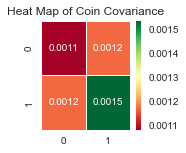

['BTC-USD', 'ETH-USD']


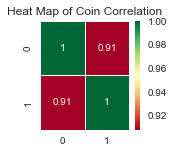

In [23]:
# Takes in cov matrix and returns correlation coeff matrix wz vals e (0, 1)
def correlation_coeffs(cov):
    l = len(cov)
    coeffs = np.zeros((l, l))
    for i in range(l):
        for j in range(l):
            coeffs[i, j] = cov[i, j] / (math.sqrt(cov[i, i]) * math.sqrt(cov[j, j]))
    return coeffs
    
def covariance(coins, start, end):
    # input: coins array, start date, end date
    # output: covariance matrix
    # also prints covariance matrix

    numcoins = len(coins)
    numdays = math.ceil((end - start).days)

    coin_returns = np.zeros((numcoins, numdays))
    for i in range(numcoins):
        data = yf.Ticker(coins[i]).history( interval='1d', start=start , end = end)
        data = np.log(1 + data['Close'].pct_change()).dropna()  # Normalized, interval % return over ~4 months
        coin_returns[i, 0:len(data)] = data

    # Avg returns
    avg_coin_returns = np.zeros(numcoins)
    for coin in range(numcoins):
        sum = 0
        num = 0
        for day in range(numdays):
            retrn = coin_returns[coin, day]
            if retrn != 0:
                sum += retrn
                num += 1
        avg_coin_returns[coin] = sum / num
        # Sample weekly covariances
    cov = np.zeros((numcoins, numcoins))

    for i in range(numcoins):
        for j in range(numcoins):
            sum = 0
            num = 0
            for k in range(numdays):
                xi = coin_returns[i, k]
                yi = coin_returns[j, k]
                # Only calculate covariance at this point if we have data for both asset i and j
                if (xi != 0) and (yi != 0):
                    sum += ( avg_coin_returns[i] - xi ) * ( avg_coin_returns[j] - yi )
                    num += 1
            cov[i, j] = sum / (num-1) # n-1 for sample covariance

    plt.style.use("seaborn")
    print("cov : ",cov)
 
    # 3. Plot correlations heatmap
    plt.figure(figsize=(numcoins,numcoins))
    heat_map = sbn.heatmap( cov, linewidth = 1 , annot = True , cmap = "RdYlGn")
    plt.title( "Heat Map of Coin Covariance" )
    plt.show()
    return cov


start = dt.date(year = 2022, month = 1, day = 1)
end = dt.date.today()
cov = covariance (COINS, start, end)
correlations = correlation_coeffs(cov)
# 3. Plot correlation heatmap
plt.figure(figsize=(len(correlations),len(correlations)))
heat_map = sbn.heatmap( correlations, linewidth = 1 , annot = True , cmap = "RdYlGn")
print(COINS)
plt.title( "Heat Map of Coin Correlation" )
plt.show()

In [24]:
zscores = stats.zscore(price_ratio[5:]-avg_price_ratio)
print(zscores)

[-6.15279970e-01  1.93940724e+00  1.87521017e+00  1.09647582e+00
  8.37957369e-01  8.92866079e-02 -3.42099432e-01  8.00382412e-03
 -2.43242708e+00 -2.05264493e+00 -1.40060480e+00 -1.51749588e+00
 -1.91782862e+00 -1.68765927e-01 -2.68337731e-01 -2.92805339e-01
 -2.04394941e-02  1.00660294e-01  1.62809853e-01  2.84332855e-01
 -3.00898694e-01  5.22276539e-01  1.16834706e+00  1.06478328e+00
 -5.12460715e-01 -1.26745373e-01 -8.38984832e-01 -1.93136188e+00
 -1.84487624e+00 -1.51793724e+00 -2.17787392e+00 -2.39908950e+00
 -3.00495141e+00 -1.96034846e+00 -1.18201366e+00 -6.45080870e-01
 -8.16086213e-01 -3.83368537e+00 -3.67163952e+00 -4.13565656e+00
 -2.05292840e+00 -3.24166243e-01 -9.74724545e-01 -8.98555542e-01
  3.02151010e-01  3.05086792e-01 -2.86275546e-01  2.72898904e-01
 -2.52612999e-01 -1.93096635e-01  9.37856101e-01  1.95124021e+00
  1.27509517e+00  5.91525158e-01  9.59977565e-01  5.24415784e-01
 -1.90345007e-01  4.35340040e-01  2.53542148e-01  6.06930661e-01
 -1.13681529e+00 -8.80840

In [27]:
def buy_sell(unit):
    pnl = 0
    prev_zscore = 0
    for i in range(len(zscores)-5):
        if zscores[i] > 2:
            print("- - - zscore > 2 - - -")
            print("Buy " +str(avg_price_ratio[i]*unit)+" of "+COINS[1])
            print("Sell 1 unit of "+COINS[0])
            pnl = pnl - prices[i, 1] * avg_price_ratio[i] * unit + prices[i, 0] * unit
        else if zscores[i] < -2:
            print("- - - zscore < -2 - - -")
            print("Buy 1 unit of "+COINS[0])
            print("Sell "+str(avg_price_ratio[i]*unit)+" of "+COINS[1])
            pnl = pnl - prices[i, 1] * unit + prices[i, 0] * avg_price_ratio[i] * unit            
    return pnl
print(buy_sell(0.1))

- - - zscore < -2 - - -
Buy 1 unit of BTC-USD
Sell 5.591287515688535 of ETH-USD
- - - zscore < -2 - - -
Buy 1 unit of BTC-USD
Sell 5.529424319055442 of ETH-USD
- - - zscore < -2 - - -
Buy 1 unit of BTC-USD
Sell 4.951885424572282 of ETH-USD
- - - zscore < -2 - - -
Buy 1 unit of BTC-USD
Sell 4.850565436913026 of ETH-USD
- - - zscore < -2 - - -
Buy 1 unit of BTC-USD
Sell 4.731285002764684 of ETH-USD
- - - zscore < -2 - - -
Buy 1 unit of BTC-USD
Sell 4.312268073809873 of ETH-USD
- - - zscore < -2 - - -
Buy 1 unit of BTC-USD
Sell 4.214221791014135 of ETH-USD
- - - zscore < -2 - - -
Buy 1 unit of BTC-USD
Sell 4.0821105494732945 of ETH-USD
- - - zscore < -2 - - -
Buy 1 unit of BTC-USD
Sell 3.9670735635803562 of ETH-USD
- - - zscore > 2 - - -
Buy 4.0221856159442515 of ETH-USD
Sell 1 unit of BTC-USD
- - - zscore > 2 - - -
Buy 4.2864725153807095 of ETH-USD
Sell 1 unit of BTC-USD
- - - zscore > 2 - - -
Buy 4.374190475069824 of ETH-USD
Sell 1 unit of BTC-USD
- - - zscore < -2 - - -
Buy 1 unit of B

In [26]:
def plot_ratio(token1, token2):
    df1 = moving_average(token1)
    df2 = moving_average(token2)
    times = df1.iloc[:0]
    ratios = []
    for i in range(0, times.len()):
        ratio.append(df1.iloc[:1][i]/df2.iloc[:1][1])
    plt.plot(times, ratios)def trade(zscore, asset1, asset2):
    if zscore > 2:
        print("Buy " +ratio_price(asset1, asset2)+" units of "+asset2)
        print("Sell 1 unit of "+asset1)
    if zscore < -2:
        print("Buy 1 unit of "+asset1)
        print("Sell "+ratio_price(asset1, asset2)+" units of "+asset2)
 


SyntaxError: invalid syntax (Temp/ipykernel_14992/3670336579.py, line 8)

In [ ]:
def graph_ratio(token1, token2):
    mvavg1 = moving_avg(token1)
    mvavg2 = moving_avg(token2)
    ratios = []
    index = 0
    for avg in mvavg1:
        ratios.append(avg/mvavg2[index])
    plt.plot(ratios)
    plt.title('Ratio of ' + token1 + " to " + token2)
